# 2-卷积神经网络应用
## 使用TensorFlow实现卷积神经网络，并应用于手势识别

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
import cnn_utils

%matplotlib inline
np.random.seed(1)

tf.disable_eager_execution() 

[2]


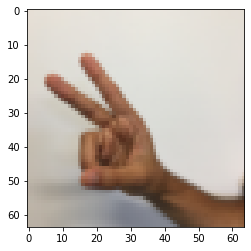

In [4]:
# 加载训练集
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes = cnn_utils.load_dataset()

index = 6
plt.imshow(X_train_orig[index])
print(Y_train_orig[:,index])

In [5]:
X_train = X_train_orig / 255 
X_test = X_test_orig / 255
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig,6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig,6).T

conv_layers = {}

X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((1080, 64, 64, 3), (1080, 6), (120, 64, 64, 3), (120, 6))

## (1) 为session创建占位符

In [6]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    """创建占位符"""
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0]) # 输入样本数量不固定，用None占位
    Y = tf.placeholder(tf.float32,[None,n_y])
    
    
    return X,Y

In [7]:
# 测试占位符
X,Y = create_placeholders(64,64,3,6)
X,Y

(<tf.Tensor 'Placeholder:0' shape=(None, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(None, 6) dtype=float32>)

## （2）初始化参数
###   现在我们将使用tf.glorot_uniform_initializer(seed = 0) 来初始化权值/过滤器W 1 W1W1、W 2 W2W2。在这里，我们不需要考虑偏置，因为TensorFlow会考虑到的。需要注意的是我们只需要初始化为2D卷积函数，全连接层TensorFlow会自动初始化的。

In [8]:
def init_params():
    """初始化参数"""
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.glorot_uniform_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.glorot_uniform_initializer(seed=0))
    
    params = {"W1":W1,"W2":W2}
    
    return params

In [9]:
# 测试初始化参数
tf.reset_default_graph()
with tf.Session() as sess_test:
    params = init_params()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print(params["W1"].eval()[1,1,1])
    print(params["W2"].eval()[1,1,1])
    
    sess_test.close()

[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## (3) 前向传播
### tf.nn.conv2d(X,W1,strides=[1,s,s,1],padding='SAME'):给定输入X XX和一组过滤器W 1 W1W1，这个函数将会自动使用W 1 W1W1来对X XX进行卷积，第三个输入参数是**[1,s,s,1]**是指对于输入 (m, n_H_prev, n_W_prev, n_C_prev)而言，每次滑动的步伐。你也可以点这里阅读文档
### tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')：给定输入X XX，该函数将会使用大小为（f,f）以及步伐为(s,s)的窗口对其进行滑动取最大值
### tf.nn.relu(Z1)：计算Z1的ReLU激活
### tf.contrib.layers.flatten(P)：给定一个输入P，此函数将会把每个样本转化成一维的向量，然后返回一个tensor变量，其维度为（batch_size,k）
### tf.contrib.layers.fully_connected(F, num_outputs)：给定一个已经一维化了的输入F，此函数将会返回一个由全连接层计算过后的输出
### 使用tf.contrib.layers.fully_connected(F, num_outputs)的时候，全连接层会自动初始化权值且在你训练模型的时候它也会一直参与，所以当我们初始化参数的时候我们不需要专门去初始化它的权值。


In [10]:
def forward_prop(X,params):
    """前向传播"""
    W1 = params["W1"]
    W2 = params["W2"]
    # 第一层卷积：步长1，填充方式SAME
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    A1 = tf.nn.relu(Z1)
    # 第一层池化：8×8窗口，步长8，填充方式SAME
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")
    
    # 第二层卷积：步长1，填充方式SAME
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2 = tf.nn.relu(Z2)
    # 第二层池化：4×4窗口，步长4，填充方式SAME
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")
    
    # 张成一维向量
    P = tf.layers.flatten(P2)
    
    # 全连接层:使用线性激活函数
    Z3 = tf.layers.dense(P,6)
    
    return Z3
    

In [13]:
# 测试前向传播
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    params = init_params()
    Z3 = forward_prop(X,params)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    
    a = sess_test.run(Z3,{X:np.random.randn(2,64,64,3),Y:np.random.rand(2,6)})
    print(a)
    
    sess_test.close()

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21380/3291306687.py:18: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  P = tf.layers.flatten(P2)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21380/3291306687.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Z3 = tf.layers.dense(P,6)


[[ 0.9927579  -1.9926488   0.40574205 -1.0828865   0.5642381  -1.7546117 ]
 [ 0.93642586 -1.8676597   0.10536456 -1.0255287   0.7649098  -1.9162732 ]]


## (4) 计算成本函数
### tf.nn.softmax_cross_entropy_with_logits(logits = Z3 , lables = Y)：计算softmax的损失函数。这个函数既计算softmax的激活，也计算其损失
### tf.reduce_mean：计算的是平均值，使用它来计算所有样本的损失来得到总成本。


In [14]:
def compute_cost(Z3,Y):
    """成本函数"""
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,labels=Y))
    
    return cost

In [15]:
# 测试成本函数
tf.reset_default_graph()


with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    params = init_params()
    Z3 = forward_prop(X,params)
    cost = compute_cost(Z3,Y)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    
    a = sess_test.run(cost,{X:np.random.randn(4,64,64,3),Y:np.random.rand(4,6)})
    print(a)
    
    sess_test.close()

7.1311083


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21380/3291306687.py:18: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  P = tf.layers.flatten(P2)
E:\anaconda\lib\site-packages\keras\legacy_tf_layers\core.py:523: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21380/3291306687.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Z3 = tf.layers.dense(P,6)
E:\anaconda\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


## （5）搭建模型


In [22]:
def model(X_train,Y_train,X_test,Y_test,a=0.005,epochs=100,minibatch_size=64,isPrint=True,isPlot=True):
    """卷积神经网络模型"""
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m,n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    # 创建占位符
    X,Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    # 初始化参数
    params = init_params()
    # 前向传播
    Z3 = forward_prop(X,params)
    # 计算成本
    cost = compute_cost(Z3,Y)
    # 反向传播
    optimizer = tf.train.AdamOptimizer(learning_rate=a).minimize(cost)
    
    # 初始化全局变量
    init = tf.global_variables_initializer()
    # 开始运行
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (batch_X,batch_Y) = minibatch
                _,temp_cost = sess.run([optimizer,cost],feed_dict={X:batch_X,Y:batch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if isPrint:
                if epoch % 5 == 0:
                    print("第%d次迭代，误差为%f" % (epoch,minibatch_cost))
                    
            costs.append(minibatch_cost)
            
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.xlabel('epochs per tens')
            plt.ylabel('cost')
            plt.title("Learning rate = %f" % a)
            plt.show()
            
        # 预测
        corrent_pre = tf.equal(tf.arg_max(Z3,1),tf.arg_max(Y,1))
        acc = tf.reduce_mean(tf.cast(corrent_pre,"float"))
        print("训练集准确率：",acc.eval({X:X_train,Y:Y_train}))
        print("测试集准确率：",acc.eval({X:X_test,Y:Y_test}))
        
        return params

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21380/3291306687.py:18: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  P = tf.layers.flatten(P2)
E:\anaconda\lib\site-packages\keras\legacy_tf_layers\core.py:523: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21380/3291306687.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Z3 = tf.layers.dense(P,6)
E:\anaconda\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


第0次迭代，误差为1.917300
第5次迭代，误差为1.650866
第10次迭代，误差为1.009321
第15次迭代，误差为0.780809
第20次迭代，误差为0.611514
第25次迭代，误差为0.576609
第30次迭代，误差为0.482294
第35次迭代，误差为0.422271
第40次迭代，误差为0.382556
第45次迭代，误差为0.349630
第50次迭代，误差为0.316421
第55次迭代，误差为0.286597
第60次迭代，误差为0.270198
第65次迭代，误差为0.272672
第70次迭代，误差为0.225145
第75次迭代，误差为0.216107
第80次迭代，误差为0.194836
第85次迭代，误差为0.151462
第90次迭代，误差为0.138109
第95次迭代，误差为0.143281
第100次迭代，误差为0.115060
第105次迭代，误差为0.097909
第110次迭代，误差为0.101561
第115次迭代，误差为0.089859
第120次迭代，误差为0.097660
第125次迭代，误差为0.103518
第130次迭代，误差为0.061489
第135次迭代，误差为0.073635
第140次迭代，误差为0.055463
第145次迭代，误差为0.045061
第150次迭代，误差为0.046293
第155次迭代，误差为0.044451
第160次迭代，误差为0.031034
第165次迭代，误差为0.033218
第170次迭代，误差为0.031850
第175次迭代，误差为0.033329
第180次迭代，误差为0.024029
第185次迭代，误差为0.021549
第190次迭代，误差为0.016470
第195次迭代，误差为0.020045
第200次迭代，误差为0.015069
第205次迭代，误差为0.025352
第210次迭代，误差为0.012254
第215次迭代，误差为0.012463
第220次迭代，误差为0.009540
第225次迭代，误差为0.008877
第230次迭代，误差为0.008568
第235次迭代，误差为0.009263
第240次迭代，误差为0.008120
第245次迭代，误差为0.007005
第250次迭代，误差为0.005961
第2

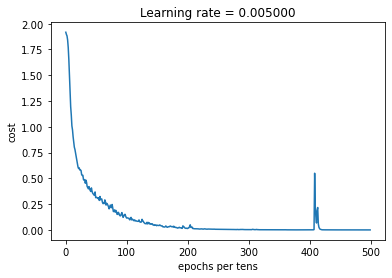

训练集准确率： 1.0
测试集准确率： 0.8833333


In [24]:
params = model(X_train,Y_train,X_test,Y_test,epochs=500)